# Notebook 2 — Clustering (K-Means)
## Projeto IA — Mundial (World Cups + FIFA Ranking)
**Grupo:** G02  
**Autores:** <António Ferreira – nº 9657>, <Mafalda Barão - nº 20446>,  <Ruben Dias - nº 23033>, <Gonçalo Gomes- nº 23039>, <João Morais - nº 23041>  
**Docente:** <Rui Fernandes>  
**Data:** <2025-12-28>

Objetivo: agrupar seleções (team, year) com base em **ranking FIFA** e **performance no Mundial** e caracterizar os clusters.


### Dados e fontes

Este projeto usa **apenas dados públicos** de futebol:

- **World Cups / Matches** (`WorldCups.csv`, `WorldCupMatches.csv`) — Kaggle: https://www.kaggle.com/datasets/abecklas/fifa-world-cup
- **FIFA World Ranking** (`fifa_ranking-2024-06-20.csv`) — Kaggle: https://www.kaggle.com/datasets/cashncarry/fifaworldranking

> Nota: os ficheiros CSV estão na pasta `/data` do repositório, para execução local sem alteração de caminhos.


In [ ]:
# Imports
import numpy as np
import pandas as pd

from datetime import datetime

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

import matplotlib.pyplot as plt

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

from IPython.display import display


### 1) Carregar datasets

In [ ]:
# Ajustar o caminho se necessário
DATA_DIR = "data"

matches = pd.read_csv(f"{DATA_DIR}/WorldCupMatches.csv")
cups = pd.read_csv(f"{DATA_DIR}/WorldCups.csv")
rank = pd.read_csv(f"{DATA_DIR}/fifa_ranking-2024-06-20.csv")

rank["rank_date"] = pd.to_datetime(rank["rank_date"], errors="coerce")

print("matches:", matches.shape)
print("cups:", cups.shape)
print("rank:", rank.shape)


matches: (4572, 20)
cups: (22, 10)
rank: (67472, 8)


### 2) Preparação: dataset por (team, year)
Criamos um registo por seleção e ano do Mundial, com métricas de performance e *snapshot* do ranking FIFA antes do Mundial.

In [ ]:
def norm_team(x):
    if pd.isna(x):
        return x
    return str(x).strip()

# Normalizar nomes
matches["Home Team Name"] = matches["Home Team Name"].map(norm_team)
matches["Away Team Name"] = matches["Away Team Name"].map(norm_team)

cups["Winner"] = cups["Winner"].map(norm_team)

rank["country_full"] = rank["country_full"].map(norm_team)
rank = rank.dropna(subset=["rank_date"]).copy()
rank = rank.sort_values(["country_full", "rank_date"]).rename(columns={"country_full": "team"})

# Long format por equipa/jogo
home = matches[["Year","Stage","Home Team Name","Home Team Goals","Away Team Goals"]].copy()
home.columns = ["Year","Stage","team","goals_for","goals_against"]

away = matches[["Year","Stage","Away Team Name","Away Team Goals","Home Team Goals"]].copy()
away.columns = ["Year","Stage","team","goals_for","goals_against"]

long = pd.concat([home, away], ignore_index=True)

# Tipos e limpeza
long = long.dropna(subset=["Year","team","goals_for","goals_against"]).copy()
long["Year"] = pd.to_numeric(long["Year"], errors="coerce").astype("Int64")
long["goals_for"] = pd.to_numeric(long["goals_for"], errors="coerce")
long["goals_against"] = pd.to_numeric(long["goals_against"], errors="coerce")
long = long.dropna(subset=["Year","goals_for","goals_against"]).copy()
long["Year"] = long["Year"].astype(int)

# Resultados/estatísticas
long["goal_diff"] = long["goals_for"] - long["goals_against"]
long["result"] = np.where(long["goal_diff"] > 0, "W", np.where(long["goal_diff"] < 0, "L", "D"))
long["points"] = np.select(
    [long["result"] == "W", long["result"] == "D", long["result"] == "L"],
    [3, 1, 0],
    default=0
)

def stage_level(stage):
    if pd.isna(stage):
        return np.nan
    s = str(stage).strip().lower()
    if s.startswith("group"):
        return 1
    if s in ["first round", "preliminary round"]:
        return 1
    if s == "round of 16":
        return 2
    if "quarter" in s:
        return 3
    if "semi" in s:
        return 4
    if "third" in s or "match for third" in s or "play-off for third" in s:
        return 5
    if s == "final":
        return 6
    return np.nan

def stage_label(level):
    if pd.isna(level):
        return "Unknown"
    level = int(level)
    return {
        1: "Group/1st round",
        2: "Round of 16",
        3: "Quarter-finals",
        4: "Semi-finals",
        5: "Third-place match",
        6: "Final",
    }.get(level, "Unknown")

long["stage_level"] = long["Stage"].map(stage_level)

team_year = long.groupby(["Year","team"], as_index=False).agg(
    games_played=("result","size"),
    wins=("result", lambda x: (x=="W").sum()),
    draws=("result", lambda x: (x=="D").sum()),
    losses=("result", lambda x: (x=="L").sum()),
    goals_for=("goals_for","sum"),
    goals_against=("goals_against","sum"),
    goal_diff=("goal_diff","sum"),
    points_earned=("points","sum"),
    max_stage_level=("stage_level","max"),
)
team_year["stage_reached"] = team_year["max_stage_level"].map(stage_label)

# Snapshot do ranking FIFA antes do Mundial: último ranking <= 01-06 do ano
team_year["cutoff_date"] = pd.to_datetime(team_year["Year"].astype(str) + "-06-01")
team_year = team_year.sort_values(["cutoff_date","team"]).reset_index(drop=True)
rank_sorted = rank.sort_values(["rank_date","team"]).reset_index(drop=True)

team_year = pd.merge_asof(
    team_year,
    rank_sorted,
    left_on="cutoff_date",
    right_on="rank_date",
    by="team",
    direction="backward"
)

# Flag "já foi campeão antes"
winners = cups[["Year","Winner"]].dropna().copy()
winners["Year"] = winners["Year"].astype(int)

def champion_before(team, year):
    return int(((winners["Year"] < year) & (winners["Winner"] == team)).any())

team_year["champion_before"] = team_year.apply(lambda r: champion_before(r["team"], r["Year"]), axis=1)

# Para clustering: usar anos com ranking disponível (rankings começam em 1992)
team_year = team_year[team_year["Year"] >= 1994].copy()
team_year = team_year.dropna(subset=["rank","total_points","confederation"]).copy()

print("team_year:", team_year.shape)
display(team_year[["Year","team","rank","total_points","confederation","stage_reached","champion_before"]].head(10))


team_year: (174, 21)


,Year,team,rank,total_points,confederation,stage_reached,champion_before
242,1994,Argentina,6.0,55.0,CONMEBOL,Round of 16,1
243,1994,Belgium,34.0,40.0,UEFA,Round of 16,0
244,1994,Bolivia,43.0,35.0,CONMEBOL,Group/1st round,0
245,1994,Brazil,1.0,59.0,CONMEBOL,Final,1
246,1994,Bulgaria,29.0,44.0,UEFA,Third-place match,0
247,1994,Cameroon,24.0,46.0,CAF,Group/1st round,0
248,1994,Colombia,18.0,50.0,CONMEBOL,Group/1st round,0
249,1994,Germany,2.0,59.0,UEFA,Quarter-finals,0
250,1994,Greece,32.0,41.0,UEFA,Group/1st round,0
251,1994,Italy,16.0,50.0,UEFA,Final,1


### 3) Seleção do número de clusters (K)
Vamos testar vários valores de K e comparar **Inertia** (método do cotovelo) e **Silhouette Score**.

In [ ]:
num_cols = [
    "rank","total_points",
    "games_played","wins","draws","losses",
    "goals_for","goals_against","goal_diff",
    "points_earned","champion_before"
]

X = team_year[num_cols].copy()
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

ks = range(2, 11)
inertias, silhouettes = [], []

for k in ks:
    km = KMeans(n_clusters=k, random_state=RANDOM_SEED, n_init=10)
    labels = km.fit_predict(X_scaled)
    inertias.append(km.inertia_)
    silhouettes.append(silhouette_score(X_scaled, labels))

tuning = pd.DataFrame({"k": list(ks), "inertia": inertias, "silhouette": silhouettes})
display(tuning)


,k,inertia,silhouette
0,2,1306.908624,0.365402
1,3,1131.250753,0.186847
2,4,1023.186502,0.200218
3,5,926.959202,0.205342
4,6,843.748956,0.203451
5,7,775.701845,0.167126
6,8,702.205109,0.183804
7,9,656.733425,0.189699
8,10,632.441369,0.182152


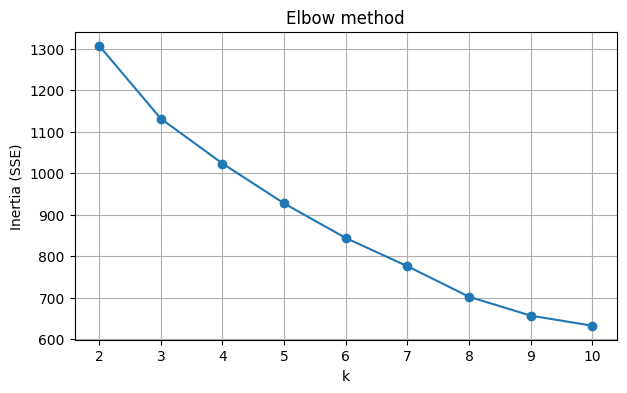

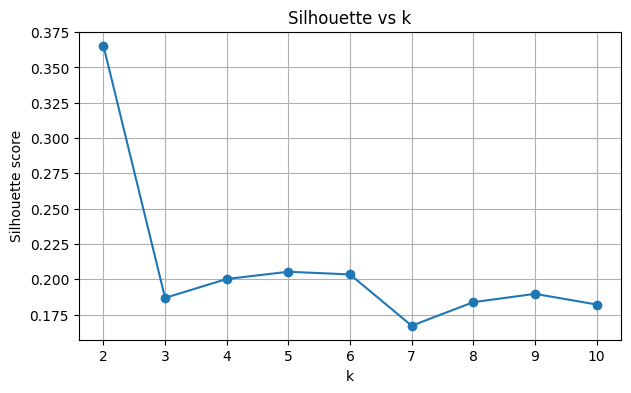

In [ ]:
# Gráficos: Inertia e Silhouette
plt.figure(figsize=(7,4))
plt.plot(tuning["k"], tuning["inertia"], marker="o")
plt.xlabel("k")
plt.ylabel("Inertia (SSE)")
plt.title("Elbow method")
plt.grid(True)
plt.show()

plt.figure(figsize=(7,4))
plt.plot(tuning["k"], tuning["silhouette"], marker="o")
plt.xlabel("k")
plt.ylabel("Silhouette score")
plt.title("Silhouette vs k")
plt.grid(True)
plt.show()


### 4) Treinar o K-Means com K escolhido
Nesta amostra, o **silhouette** tende a ser mais alto para K=2, mas isso separa apenas *fortes vs fracos*. Para obter grupos mais interpretáveis sem criar clusters muito pequenos, escolhemos **K=4** (bom compromisso entre cotovelo e estabilidade).

In [ ]:
K_FINAL = 4

kmeans = KMeans(n_clusters=K_FINAL, random_state=RANDOM_SEED, n_init=10)
team_year["cluster"] = kmeans.fit_predict(X_scaled)

print("Tamanho de cada cluster:")
display(team_year["cluster"].value_counts().sort_index())


Tamanho de cada cluster:


cluster
0    58
1    21
2    25
3    70
Name: count, dtype: int64

### 5) Caracterização dos clusters
Inclui:
- número de elementos por cluster
- estatísticas (média/std/min/max) dos atributos numéricos
- distribuição de atributos categóricos (confederação e fase atingida)

In [ ]:
# 5.1 Estatísticas numéricas
stats_num = team_year.groupby("cluster")[num_cols].agg(["mean","std","min","max"])
display(stats_num)

# 5.2 Distribuição de categóricas (percentagens)
def pct_table(df, col):
    ct = pd.crosstab(df["cluster"], df[col], normalize="index")
    return (ct * 100).round(1)

conf_pct = pct_table(team_year, "confederation")
stage_pct = pct_table(team_year, "stage_reached")

print("Distribuição por confederação (%):")
display(conf_pct)

print("Distribuição por fase atingida (%):")
display(stage_pct)


rank                        total_points                    \
              mean        std  min    max         mean         std   min   
cluster                                                                    
0        21.120690  15.300588  2.0   78.0   497.672414  376.203957  37.0   
1         7.333333   5.341660  1.0   24.0   808.428571  447.210529  55.0   
2        10.160000   7.301141  1.0   25.0   723.680000  477.860136  50.0   
3        31.771429  17.631634  5.0  105.0   505.928571  327.383271  35.0   

                games_played            ... goal_diff       points_earned  \
            max         mean       std  ...       min   max          mean   
cluster                                 ...                                 
0        1249.0     3.982759  0.964117  ...      -3.0   6.0      5.672414   
1        1611.0     4.047619  0.920662  ...      -4.0   8.0      6.190476   
2        1565.0     7.640000  1.496663  ...     -11.0  23.0     16.480000   
3        1161.0     3.357143  0.799197  ...     -12.0   2.0      2.400000   

                          champion_before               
              std min max            mean  std min max  
cluster                                                 
0        2.529738   2  11             0.0  0.0   0   0  
1        3.982701   1  12             1.0  0.0   1   1  
2        4.547160  11  31             0.4  0.5   0   1  
3        2.182938   0  10             0.0  0.0   0   0  

[4 rows x 44 columns]

Distribuição por confederação (%):


confederation,AFC,CAF,CONCACAF,CONMEBOL,OFC,UEFA
cluster,,,,,,
0,10.3,15.5,15.5,8.6,1.7,48.3
1,0.0,0.0,0.0,42.9,0.0,57.1
2,0.0,0.0,0.0,28.0,0.0,72.0
3,22.9,24.3,12.9,11.4,0.0,28.6


Distribuição por fase atingida (%):


stage_reached,Final,Group/1st round,Quarter-finals,Round of 16,Third-place match
cluster,,,,,
0,0.0,36.2,20.7,41.4,1.7
1,0.0,38.1,38.1,23.8,0.0
2,48.0,0.0,12.0,0.0,40.0
3,0.0,72.9,1.4,24.3,1.4


### 6) Exportar Resultados


In [ ]:
# --------------------------
# (Opcional) Exportar resultados
# --------------------------
# Guardar o dataset agregador com o cluster atribuído
team_year.to_csv("clusters_team_year.csv", index=False)
print("Guardado: clusters_team_year.csv")


### 7) Interpretação rápida (K=4)

- **Cluster 1 (≈21 seleções)**: *Elite histórica*.  
  Apresenta **rank médio muito baixo (melhor)** (~7), **muitos pontos FIFA** (média ~808) e **`champion_before = 1`** (ou seja, são seleções que **já foram campeãs**). Tende a representar seleções tradicionalmente fortes.

- **Cluster 2 (≈25 seleções)**: *Top performance no torneio*.  
  Tem **rank bom** (~10) e destaca-se por **muitos jogos e pontos no Mundial** (média de jogos ~7.6; pontos ganhos ~16.5). Na distribuição por fase, concentra grande parte em **Final (48%)** e **3.º lugar (40%)**, logo representa edições em que a seleção chegou **muito longe**.

- **Cluster 0 (≈58 seleções)**: *Competitivas / “meio da tabela”*.  
  **Rank intermédio** (~21) e desempenho razoável: aparece bastante em **Oitavos (41%)** e tem alguma presença em **Quartos (20.7%)**, mas também cai na fase de grupos. Representa seleções que competem bem, mas sem consistência de topo.

- **Cluster 3 (≈70 seleções)**: *Menos competitivas*.  
  **Rank médio pior** (~32) e **poucos pontos no Mundial** (pontos ganhos ~2.4), com forte concentração em **Group/1st round (72.9%)**. Representa seleções que, na maioria das edições, **não passam a fase de grupos**.

**Resumo:** os clusters separam bem (i) seleções **historicamente campeãs** (C1), (ii) seleções com **campanhas muito profundas** (C2), (iii) seleções **intermédias** (C0) e (iv) seleções **menos competitivas** (C3).

**Justificação do K=4:** optou-se por **K=4** por equilibrar bem a qualidade do agrupamento (redução da inércia) com a clareza de análise, gerando clusters suficientemente distintos e com tamanhos razoáveis, o que facilita a comparação de padrões de ranking FIFA, desempenho no Mundial e distribuição por confederação/fase atingida.



### Lições aprendidas

- A **normalização/standardização** das variáveis é essencial em K-Means, caso contrário o algoritmo fica dominado por atributos em escalas maiores.
- A escolha de **K** envolve equilíbrio entre qualidade (inércia/silhouette) e **interpretabilidade**: mais clusters nem sempre significa perfis mais úteis.
- A análise por cluster (médias/intervalos e distribuições por confederação/fase) é tão importante como o treino do modelo para transformar clusters em **insights**.
